<a href="https://colab.research.google.com/github/nksmarts/Ensemble-of-winning-tickets/blob/main/New_pruning_BERT_attention_heads_accuracy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Checking the GPU we are currently using**

In [ ]:
!nvidia-smi

Thu Oct 26 07:40:09 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P8     9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-89c52484-29de-5a97-f2e1-391e128a91ec)


# **Installing transformers, datasets and numpy library**

In [ ]:
!pip install transformers datasets numpy > /dev/null

# **Importing required libraries and modules**

In [ ]:
import numpy as np

from datasets import (
    load_dataset,
    load_metric,
    DatasetDict,
    Dataset,
)

from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    DataCollatorWithPadding,
    TrainingArguments,
    Trainer,
    set_seed,
)

# **Setting Constants**:
We're going to use SEED, for shuffling our dataset, transformer models and everywhere we use something that is done randomly so we get the same result each time. CHECKPOINT is used to when we load the model and the tokenizer of the model, you can simply change the CHECKPOINT to a similiar model and run this whole notebook and it will work; for example you can change it to bert-base-uncased.

In [ ]:
SEED = 8000
CHECKPOINT = "bert-base-uncased"

# **Loading sst2 Dataset from glue Benchmark**

In [ ]:
sst2_datasets = load_dataset("glue", "sst2")

# **Creating a Smaller Version of sst2 Dataset**

In [ ]:
select_example = sst2_datasets["train"].select(range(300))

custom_sst2 = DatasetDict({
    "train": sst2_datasets["train"].shuffle(seed=SEED).select(range(8000)).flatten_indices(),
    "validation": sst2_datasets["validation"],
    "test": sst2_datasets["train"].shuffle(seed=SEED).select(range(300, 400)).flatten_indices()
})

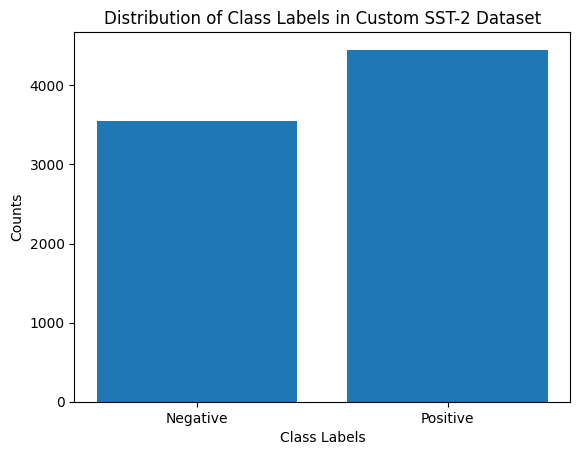

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Create a Pandas DataFrame to store the class labels and their counts
labels = ["Negative", "Positive"]
train_counts = [len(custom_sst2["train"].filter(lambda example: example["label"] == 0)),
                len(custom_sst2["train"].filter(lambda example: example["label"] == 1))]
data = {"Class Labels": labels, "Counts": train_counts}
df = pd.DataFrame(data)

# Plot the bar chart using matplotlib
plt.bar(df["Class Labels"], df["Counts"])

# Set the labels and title
plt.xlabel("Class Labels")
plt.ylabel("Counts")
plt.title("Distribution of Class Labels in Custom SST-2 Dataset")

# Show the plot
plt.show()


# **Defining Compute Metric**

In [ ]:
from sklearn.metrics import accuracy_score

In [ ]:
def compute_metrics(eval_preds):
    logits, labels = eval_preds
    predictions = np.argmax(logits, axis=-1)
    accuracy = accuracy_score(labels, predictions)
    return {"accuracy": accuracy}


# **Set Transformers Seed**
If we don't set the seed, the first time we train a model, the transformers library is going to set a seed itself. more information about this: https://discuss.huggingface.co/t/multiple-training-will-give-exactly-the-same-result-except-for-the-first-time/8493?u=smmousavi

In [ ]:
set_seed(SEED)

# **Loading the Model and the Tokenizer and Tokenizing the Dataset**

In [ ]:
num_labels = len(custom_sst2["train"].unique('label'))

model = AutoModelForSequenceClassification.from_pretrained(CHECKPOINT, num_labels=num_labels)
tokenizer = AutoTokenizer.from_pretrained(CHECKPOINT)

def tokenize_function(example):
    return tokenizer(example["sentence"], truncation=True)

tokenized_datasets = custom_sst2.map(tokenize_function, batched=True)
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/872 [00:00<?, ? examples/s]

# **Initialize an empty ensemble set to store the winning tickets?**

In [ ]:
ensemble_set = []

In [ ]:
!pip install torch

# **Set the training parameters:**

In [ ]:
import torch
import torch.optim as optim
import torch.nn as nn
from transformers import BertForSequenceClassification

# Set the training parameters:
num_iterations = 5  # Number of training iterations
learning_rate = 2e-5  # Learning rate for optimization
batch_size = 16  # Batch size for training
convergence_threshold = 0.001  # Threshold for convergence criteria

# For each ensemble iteration:
for iteration in range(num_iterations):

    # Initialize a mask matrix for the attention heads with all values set to 1
    mask_matrix = torch.ones(model.config.num_hidden_layers, model.config.num_attention_heads)

    # Randomly initialize a sub-network (ticket) based on the BERT architecture
    # Assuming you have a variable CHECKPOINT that contains the path to the checkpoint file
    checkpoint_path = CHECKPOINT
    ticket = BertForSequenceClassification.from_pretrained(checkpoint_path)

    # Set the optimizer and loss function for the sub-network
    optimizer = optim.Adam(ticket.parameters(), lr=learning_rate)
    criterion = nn.CrossEntropyLoss()


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are

# **Setting Training Arguments and Creating a Trainer Object**

In [ ]:
!pip install transformers[torch]
!pip install accelerate -U


In [ ]:
saving_folder = "custom_sst2_bert"
training_args = TrainingArguments(
    saving_folder,
    load_best_model_at_end=True,
    num_train_epochs=3,
    evaluation_strategy="steps",
    eval_steps=100,
    save_steps=100,
    metric_for_best_model="accuracy_score",
    save_total_limit=10,
)

trainer = Trainer(
    ticket,
    training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

In [ ]:
!pip install sklearn --upgrade

  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.


In [ ]:
!pip install wandb onnx -Uq


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 13.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.6/14.6 MB 64.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.6/190.6 kB 23.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 241.0/241.0 kB 31.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 8.5 MB/s eta 0:00:00


In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss,Accuracy Score
1,0.325900,0.251090,0.909404
2,0.163400,0.344963,0.907110
3,0.080300,0.449068,0.905963


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy Score
1,0.336300,0.241051,0.910550
2,0.163900,0.342103,0.905963
3,0.082600,0.411373,0.909404


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy Score
1,0.336300,0.241051,0.910550
2,0.163900,0.342103,0.905963
3,0.082600,0.411373,0.909404


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy Score
1,0.336300,0.241051,0.910550
2,0.163900,0.342103,0.905963
3,0.082600,0.411373,0.909404


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy Score
1,0.336300,0.241051,0.910550
2,0.163900,0.342103,0.905963
3,0.082600,0.411373,0.909404


Step,Training Loss,Validation Loss,Accuracy Score
100,No log,0.611232,0.872706
200,No log,0.597184,0.876147
300,No log,0.496958,0.862385
400,No log,0.369928,0.879587
500,0.322600,0.500275,0.863532
600,0.322600,0.413509,0.887615
700,0.322600,0.456039,0.886468
800,0.322600,0.392436,0.881881
900,0.322600,0.342097,0.879587
1000,0.288300,0.355426,0.895642


Step,Training Loss,Validation Loss,Accuracy Score
100,No log,0.497203,0.877294
200,No log,0.397982,0.887615
300,No log,0.489776,0.862385
400,No log,0.409433,0.875000
500,0.316900,0.448460,0.891055
600,0.316900,0.600649,0.860092
700,0.316900,0.405992,0.879587
800,0.316900,0.435905,0.878440
900,0.316900,0.349633,0.889908
1000,0.310000,0.329094,0.913991


Step,Training Loss,Validation Loss,Accuracy Score
100,No log,0.497203,0.877294
200,No log,0.397982,0.887615
300,No log,0.489776,0.862385
400,No log,0.409433,0.875000
500,0.316900,0.448460,0.891055
600,0.316900,0.600649,0.860092
700,0.316900,0.405992,0.879587
800,0.316900,0.435905,0.878440
900,0.316900,0.349633,0.889908
1000,0.310000,0.329094,0.913991


Step,Training Loss,Validation Loss,Accuracy Score
100,No log,0.497203,0.877294
200,No log,0.397982,0.887615
300,No log,0.489776,0.862385
400,No log,0.409433,0.875000
500,0.316900,0.448460,0.891055
600,0.316900,0.600649,0.860092
700,0.316900,0.405992,0.879587
800,0.316900,0.435905,0.878440
900,0.316900,0.349633,0.889908
1000,0.310000,0.329094,0.913991


Step,Training Loss,Validation Loss,Accuracy Score
100,No log,0.497203,0.877294
200,No log,0.397982,0.887615
300,No log,0.489776,0.862385
400,No log,0.409433,0.875000
500,0.316900,0.448460,0.891055
600,0.316900,0.600649,0.860092
700,0.316900,0.405992,0.879587
800,0.316900,0.435905,0.878440
900,0.316900,0.349633,0.889908
1000,0.310000,0.329094,0.913991


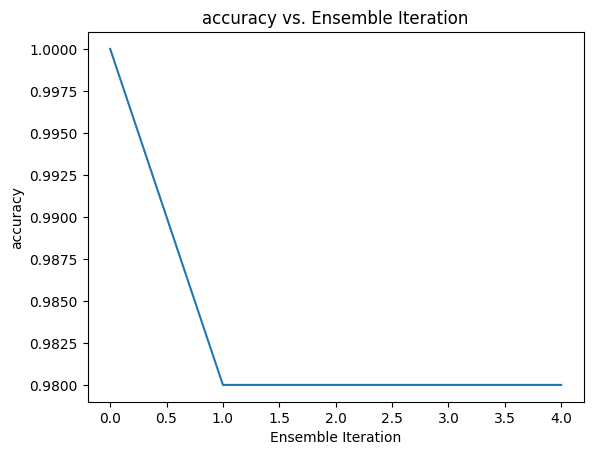

accuracy,▁▃▃▃▃█▃▃▃▃
ensemble_iteration,▁▃▅▆█
eval/accuracy_score,▆▃▁█▁▆█▁▆█▁▆█▁▆
eval/loss,▁▄█▁▄▇▁▄▇▁▄▇▁▄▇
eval/runtime,▁▄▄▆▆▅▄▇██▆▆▇▇▇
eval/samples_per_second,█▅▅▃▃▃▄▂▁▁▃▃▂▂▂
eval/steps_per_second,█▅▅▃▃▃▄▂▁▁▃▃▂▂▂
iteration,▁▃▅▆█
train/epoch,▁▁▅▅███▁▁▅▅███▁▁▅▅███▁▁▅▅███▁▁▅▅███
train/global_step,▁▁▅▅████▁▅▅████▁▅▅████▁▁▅████▁▁▅████████
train/learning_rate,█▅▁█▅▁█▅▁█▅▁█▅▁


In [ ]:
import torch
import torch.optim as optim
import torch.nn as nn
import matplotlib.pyplot as plt
from transformers import BertForSequenceClassification, Trainer, TrainingArguments
from sklearn.metrics import accuracy_score
import wandb
import os

# Initialize wandb
wandb.init(settings=wandb.Settings(start_method="fork"))

# Rest of your code ...

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = logits.argmax(-1)
    accuracy = accuracy_score(labels, predictions)
    return {"eval_accuracy_score": accuracy}


def ensemble_bert(num_iterations, learning_rate, batch_size, convergence_threshold):
    ensemble_set = []
    for iteration in range(num_iterations):
        mask_matrix = torch.ones(model.config.num_hidden_layers, model.config.num_attention_heads)
        ticket = BertForSequenceClassification.from_pretrained(checkpoint_path)
        optimizer = optim.Adam(ticket.parameters(), lr=learning_rate)
        criterion = nn.CrossEntropyLoss()

        # Define and initialize training arguments
        training_args = TrainingArguments(
            output_dir="./results",
            num_train_epochs=3,
            per_device_train_batch_size=batch_size,
            per_device_eval_batch_size=batch_size,
            learning_rate=learning_rate,
            weight_decay=0.01,
            logging_dir='./logs',
            evaluation_strategy="epoch",
            save_strategy="epoch",
            load_best_model_at_end=True,
            metric_for_best_model="eval_accuracy_score",  # Update metric name to eval_accuracy
        )

        trainer = Trainer(
            model=ticket,
            args=training_args,
            train_dataset=tokenized_datasets["train"],
            eval_dataset=tokenized_datasets["validation"],
            data_collator=data_collator,
            tokenizer=tokenizer,
            compute_metrics=compute_metrics,
        )
        trainer.train()
        predictions = trainer.predict(tokenized_datasets["test"])
        if accuracy_score(predictions.label_ids, predictions.predictions.argmax(-1)) > convergence_threshold:
            ensemble_set.append(ticket)

            # Log hyperparameters and metrics to wandb
            wandb.log({"iteration": iteration, "accuracy": accuracy_score(predictions.label_ids, predictions.predictions.argmax(-1))})

    return ensemble_set

if __name__ == "__main__":
    # Set up wandb configuration
    wandb_config = {
        "num_iterations": 5,
        "learning_rate": 2e-5,
        "batch_size": 16,
        "convergence_threshold": 0.001,
    }
    wandb.config.update(wandb_config)

    ensemble_set = ensemble_bert(
        num_iterations=wandb_config["num_iterations"],
        learning_rate=wandb_config["learning_rate"],
        batch_size=wandb_config["batch_size"],
        convergence_threshold=wandb_config["convergence_threshold"],
    )

    accuracies = []
    for iteration, model in enumerate(ensemble_set):
        trainer = Trainer(
            model=model,
            args=training_args,
            train_dataset=tokenized_datasets["train"],
            eval_dataset=tokenized_datasets["validation"],
            data_collator=data_collator,
            tokenizer=tokenizer,
            compute_metrics=compute_metrics,
        )
        trainer.train()
        predictions = trainer.predict(tokenized_datasets["test"])
        accuracy = accuracy_score(predictions.label_ids, predictions.predictions.argmax(-1))
        accuracies.append(accuracy)

        # Log accuracy for each ensemble iteration to wandb
        wandb.log({"ensemble_iteration": iteration, "accuracy": accuracy})

    # Save the ensemble_set
    os.makedirs("ensemble_models", exist_ok=True)
    for i, model in enumerate(ensemble_set):
        model.save_pretrained(f"ensemble_models/model_{i}")

    # Save the best model to the Hugging Face Hub
    best_model_index = accuracies.index(max(accuracies))
    best_model = ensemble_set[best_model_index]
    model_name = "your_hub_username/your_model_name"
    best_model.save_pretrained(model_name)
    tokenizer.save_pretrained(model_name)
    wandb.save(f"ensemble_models/model_{best_model_index}/config.json")

    # Plotting Accuracy vs. Ensemble Iteration
    plt.plot(range(len(accuracies)), accuracies)
    plt.title("accuracy vs. Ensemble Iteration")
    plt.xlabel("Ensemble Iteration")
    plt.ylabel("accuracy")
    plt.show()

    # Finish wandb run
    wandb.finish()


wandb: Currently logged in as: nyalalani-smarts (smarts-raja-venu). Use `wandb login --relogin` to force relogin


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy Score
1,0.341600,0.251889,0.905963
2,0.167400,0.347189,0.904817
3,0.090100,0.422508,0.909404


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy Score
1,0.336300,0.241051,0.910550
2,0.163900,0.342103,0.905963
3,0.082600,0.411373,0.909404


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy Score
1,0.336300,0.241051,0.910550
2,0.163900,0.342103,0.905963
3,0.082600,0.411373,0.909404


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy Score
1,0.336300,0.241051,0.910550
2,0.163900,0.342103,0.905963
3,0.082600,0.411373,0.909404


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy Score
1,0.336300,0.241051,0.910550
2,0.163900,0.342103,0.905963
3,0.082600,0.411373,0.909404


Number of tickets (subnets) in the ensemble: 5


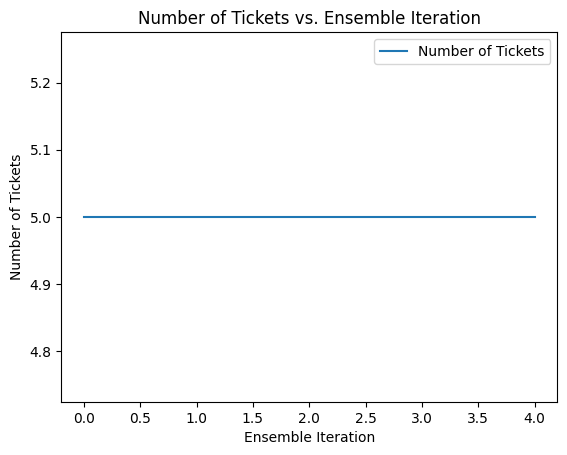

Step,Training Loss,Validation Loss,Accuracy Score
100,No log,0.475944,0.902523
200,No log,0.579925,0.883028
300,No log,0.618579,0.857798
400,No log,0.851005,0.826835
500,0.261000,0.652312,0.858945
600,0.261000,0.406256,0.885321
700,0.261000,0.512645,0.879587
800,0.261000,0.498606,0.873853
900,0.261000,0.471880,0.883028
1000,0.282300,0.487355,0.877294


Step,Training Loss,Validation Loss,Accuracy Score
100,No log,0.497203,0.877294
200,No log,0.397982,0.887615
300,No log,0.489776,0.862385
400,No log,0.409433,0.875000
500,0.316900,0.448460,0.891055
600,0.316900,0.600649,0.860092
700,0.316900,0.405992,0.879587
800,0.316900,0.435905,0.878440
900,0.316900,0.349633,0.889908
1000,0.310000,0.329094,0.913991


Step,Training Loss,Validation Loss,Accuracy Score
100,No log,0.497203,0.877294
200,No log,0.397982,0.887615
300,No log,0.489776,0.862385
400,No log,0.409433,0.875000
500,0.316900,0.448460,0.891055
600,0.316900,0.600649,0.860092
700,0.316900,0.405992,0.879587
800,0.316900,0.435905,0.878440
900,0.316900,0.349633,0.889908
1000,0.310000,0.329094,0.913991


Step,Training Loss,Validation Loss,Accuracy Score
100,No log,0.497203,0.877294
200,No log,0.397982,0.887615
300,No log,0.489776,0.862385
400,No log,0.409433,0.875000
500,0.316900,0.448460,0.891055
600,0.316900,0.600649,0.860092
700,0.316900,0.405992,0.879587
800,0.316900,0.435905,0.878440
900,0.316900,0.349633,0.889908
1000,0.310000,0.329094,0.913991


Step,Training Loss,Validation Loss,Accuracy Score
100,No log,0.497203,0.877294
200,No log,0.397982,0.887615
300,No log,0.489776,0.862385
400,No log,0.409433,0.875000
500,0.316900,0.448460,0.891055
600,0.316900,0.600649,0.860092
700,0.316900,0.405992,0.879587
800,0.316900,0.435905,0.878440
900,0.316900,0.349633,0.889908
1000,0.310000,0.329094,0.913991


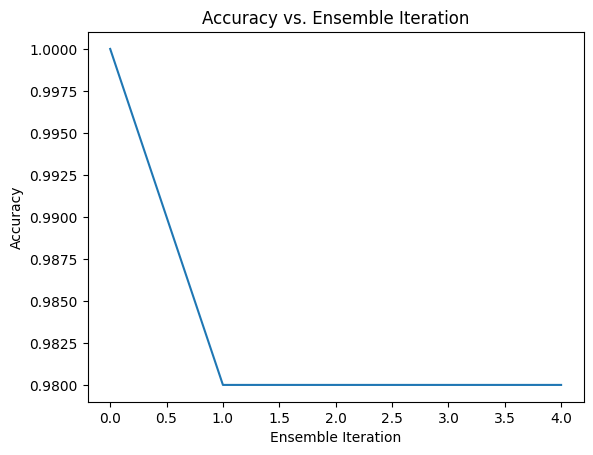

accuracy,▅▁▁▁▁█▁▁▁▁
ensemble_iteration,▁▃▅▆█
eval/accuracy_score,▂▁▇█▂▇█▂▇█▂▇█▂▇
eval/loss,▁▅█▁▅█▁▅█▁▅█▁▅█
eval/runtime,▁▇▇▇█▅▇█▇▇▇▅▆▆█
eval/samples_per_second,█▂▂▂▁▄▂▁▂▂▂▄▃▃▁
eval/steps_per_second,█▂▂▂▁▄▂▁▂▂▂▄▃▃▁
iteration,▁▃▅▆█
train/epoch,▁▁▅▅███▁▁▅▅███▁▁▅▅███▁▁▅▅███▁▁▅▅███
train/global_step,▁▁▅▅████▁▅▅████▁▅▅████▁▁▅████▁▁▅████████
train/learning_rate,█▅▁█▅▁█▅▁█▅▁█▅▁


In [ ]:
import torch
import torch.optim as optim
import torch.nn as nn
import matplotlib.pyplot as plt
from transformers import BertForSequenceClassification, Trainer, TrainingArguments, BertTokenizer
from sklearn.metrics import accuracy_score
import wandb
import os

# Initialize wandb
wandb.init(settings=wandb.Settings(start_method="fork"))

# Rest of your code ...

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = logits.argmax(-1)
    accuracy = accuracy_score(labels, predictions)
    return {"eval_accuracy_score": accuracy}

def ensemble_bert(num_iterations, learning_rate, batch_size, convergence_threshold):
    ensemble_set = []
    for iteration in range(num_iterations):
        mask_matrix = torch.ones(model.config.num_hidden_layers, model.config.num_attention_heads)
        ticket = BertForSequenceClassification.from_pretrained(checkpoint_path)
        optimizer = optim.Adam(ticket.parameters(), lr=learning_rate)
        criterion = nn.CrossEntropyLoss()

        # Define and initialize training arguments
        training_args = TrainingArguments(
            output_dir="./results",
            num_train_epochs=3,
            per_device_train_batch_size=batch_size,
            per_device_eval_batch_size=batch_size,
            learning_rate=learning_rate,
            weight_decay=0.01,
            logging_dir='./logs',
            evaluation_strategy="epoch",
            save_strategy="epoch",
            load_best_model_at_end=True,
            metric_for_best_model="eval_accuracy_score",
        )

        trainer = Trainer(
            model=ticket,
            args=training_args,
            train_dataset=tokenized_datasets["train"],
            eval_dataset=tokenized_datasets["validation"],
            data_collator=data_collator,
            tokenizer=tokenizer,
            compute_metrics=compute_metrics,
        )
        trainer.train()
        predictions = trainer.predict(tokenized_datasets["test"])
        if accuracy_score(predictions.label_ids, predictions.predictions.argmax(-1)) > convergence_threshold:
            ensemble_set.append(ticket)

            # Log hyperparameters and metrics to wandb
            wandb.log({"iteration": iteration, "accuracy": accuracy_score(predictions.label_ids, predictions.predictions.argmax(-1))})

    return ensemble_set

if __name__ == "__main__":
    # Set up wandb configuration
    wandb_config = {
        "num_iterations": 5,
        "learning_rate": 2e-5,
        "batch_size": 16,
        "convergence_threshold": 0.001,
    }
    wandb.config.update(wandb_config)

    ensemble_set = ensemble_bert(
        num_iterations=wandb_config["num_iterations"],
        learning_rate=wandb_config["learning_rate"],
        batch_size=wandb_config["batch_size"],
        convergence_threshold=wandb_config["convergence_threshold"],
    )

    num_tickets = len(ensemble_set)
    print("Number of tickets (subnets) in the ensemble:", num_tickets)

    # Plotting Number of Tickets vs. Ensemble Iteration
    plt.plot(range(len(ensemble_set)), [num_tickets] * len(ensemble_set), label="Number of Tickets")
    plt.title("Number of Tickets vs. Ensemble Iteration")
    plt.xlabel("Ensemble Iteration")
    plt.ylabel("Number of Tickets")
    plt.legend()
    plt.show()

    accuracy_scores = []
    for iteration, model in enumerate(ensemble_set):
        trainer = Trainer(
            model=model,
            args=training_args,
            train_dataset=tokenized_datasets["train"],
            eval_dataset=tokenized_datasets["validation"],
            data_collator=data_collator,
            tokenizer=tokenizer,
            compute_metrics=compute_metrics,
        )
        trainer.train()
        predictions = trainer.predict(tokenized_datasets["test"])
        accuracy = accuracy_score(predictions.label_ids, predictions.predictions.argmax(-1))
        accuracy_scores.append(accuracy)

        # Log accuracy for each ensemble iteration to wandb
        wandb.log({"ensemble_iteration": iteration, "accuracy": accuracy})

    # Save the ensemble_set
    os.makedirs("ensemble_models", exist_ok=True)
    for i, model in enumerate(ensemble_set):
        model.save_pretrained(f"ensemble_models/model_{i}")

    # Save the best model to the Hugging Face Hub
    best_model_index = accuracy_scores.index(max(accuracy_scores))
    best_model = ensemble_set[best_model_index]
    model_name = "your_hub_username/your_model_name"
    best_model.save_pretrained(model_name)
    tokenizer.save_pretrained(model_name)
    wandb.save(f"ensemble_models/model_{best_model_index}/config.json")

    # Plotting Accuracy vs. Ensemble Iteration
    plt.plot(range(len(accuracy_scores)), accuracy_scores)
    plt.title("Accuracy vs. Ensemble Iteration")
    plt.xlabel("Ensemble Iteration")
    plt.ylabel("Accuracy")
    plt.show()

    # Finish wandb run
    wandb.finish()
